## Setting up a multi-task PINN for predicting flow and CD

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset, Dataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import scipy.stats as stats


# plot layout, darkgrid
sns.set(style="darkgrid")

In [ ]:
# read the preprocessed data, the calculated averages for the 29 relevant cities
data_avg = pd.read_csv('C:/DTU/Speciale/Kode/Speciale/data/processed/averages.csv')
data_avg['city'] = data_avg['city'].str.capitalize()

# get all the cities in the data_avg
cities = data_avg['city'].unique()

# normalize by city - done here to allow for 
data_avg['norm_flow'] = data_avg.groupby('city')['avg_flow'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
data_avg['norm_occ'] = data_avg.groupby('city')['avg_occupancy'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))

In [3]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
class MultiTaskPINNModel(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(MultiTaskPINNModel, self).__init__()
        
        # Feature extraction layers
        self.feature_extractor = nn.Sequential(
            nn.Linear(1, 64),
            nn.ReLU(),
            nn.Dropout(p=dropout_prob),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Dropout(p=dropout_prob),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Dropout(p=dropout_prob)
        )
        
        # Output branch for flow prediction
        self.flow_predictor = nn.Sequential(
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Dropout(p=dropout_prob),
            nn.Linear(64, 1)
        )
        
        # Output branch for critical density prediction
        self.cd_predictor = nn.Sequential(
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Dropout(p=dropout_prob),
            nn.Linear(64, 1),
            nn.Sigmoid()  # Normalize critical density to be within [0, 1] 
            # We move this to the forward pass to be able to clamp the value to [0.01, 0.99] for stability
        )

        # Output branch for max flow prediction
        self.max_flow_predictor = nn.Sequential(
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Dropout(p=dropout_prob),
            nn.Linear(64, 1),
            nn.Sigmoid()  # Normalize max flow to be within [0, 1]
        )

        # Learnable parameter for offset
        self.offset = nn.Parameter(torch.tensor(0.0))  # Initializing offset as a learnable parameter

        # Learnable parameter for occ_scaler (scaling factor for the second parabola)
        self.occ_scaler = nn.Parameter(torch.tensor(3.0))  # Initially set to 3, can be adjusted based on data


    def forward(self, x):
        features = self.feature_extractor(x)

        flow = self.flow_predictor(features)

        critical_density = self.cd_predictor(features) 
        critical_density = torch.clamp(critical_density, 0.05, 0.95) # clamp critical density toi ensure stability by avoiding extreme values
        critical_density = critical_density.mean(dim=0, keepdim=True)  # Averaging across batch for single prediction value

        max_flow = self.max_flow_predictor(features)
        max_flow = max_flow.mean(dim=0, keepdim=True)  # Averaging across batch for single value

        # Using the learnable offset and occ_scaler
        offset = self.offset  # Directly use the learned offset parameter
        occ_scaler = self.occ_scaler  # Use occ_scaler for dynamic adjustment of the second parabola's width

        return flow, critical_density, max_flow, offset, occ_scaler


    def compute_total_loss(self, occupancy, flow, alpha=1.0):
        # Forward pass to get predictions
        predicted_flow, predicted_cd, predicted_max_flow, predicted_offset, predicted_occ_scaler = self.forward(occupancy)
        
        # Flow MSE loss
        mse_loss_flow = nn.functional.mse_loss(predicted_flow, flow)

        
        # Physics-informed loss (indirectly encourages cd and max flow learning)
        physics_loss = self.physics_informed_loss(occupancy, flow, predicted_cd, predicted_max_flow, predicted_offset, predicted_occ_scaler)

        # Total loss with scaling factor for physics-informed loss
        total_loss = mse_loss_flow + alpha * physics_loss
        return total_loss

    def physics_informed_loss(self, occupancy, flow, critical_density, max_flow, offset, occ_scaler):
        # Define physics-informed loss: encourages the flow to fit a parabolic shape around critical density
        mask_before_cd = occupancy <= critical_density
        mask_after_cd = occupancy > critical_density

        # Use max_flow - offset in parabolic fits
        parabola1_a = -(max_flow - offset) / (critical_density ** 2 + 1e-6)  # Scaling factor for left parabola
        fit1 = parabola1_a * (occupancy - critical_density) ** 2 + (max_flow - offset)

        # parabola2_a = -(max_flow - offset) / ((1 - critical_density) ** 2  + 1e-6)  # Scaling factor for right parabola
        # fit2 = parabola2_a * (occupancy - critical_density) ** 2 + (max_flow - offset)
        # Adjusting the width of the second parabola with occ_scaler
        # parabola2_a = -(max_flow - offset) / ((occ_scaler * (1 - critical_density)) ** 2 + 1e-6)  # Scaling factor for right parabola
        parabola2_a = -(max_flow - offset) / (((occ_scaler - 1) * critical_density) ** 2 + 1e-6)  # Scaling factor for right parabola
        fit2 = parabola2_a * (occupancy - critical_density) ** 2 + (max_flow - offset)

        # MSE for both fits (unless no data points in a segment, then loss is 0)
        mse_fit1 = torch.mean((flow[mask_before_cd] - fit1[mask_before_cd])**2) if torch.sum(mask_before_cd) > 0 else torch.tensor(0.0, device=flow.device)
        mse_fit2 = torch.mean((flow[mask_after_cd] - fit2[mask_after_cd])**2) if torch.sum(mask_after_cd) > 0 else torch.tensor(0.0, device=flow.device)

        # Regularization term for max flow position
        penalty_term = torch.mean(torch.relu(flow - (max_flow)))  # Penalizing flow values higher than (max_flow) - max flow penalty

        # Rguarization term for the width of the second parabola, the occ_scaler to be between 1 and 4 -scaler penalty
        penalty_term2 = torch.mean(torch.relu((occ_scaler - 5 * critical_density))) + torch.mean(torch.relu((2 * critical_density - occ_scaler))) * 5 # here we penalize the occ_scaler to be outside the range [1, 4]

        # Regularization term: Penalize small Fit 2 region
        total_points = torch.sum(mask_before_cd) + torch.sum(mask_after_cd)
        percentage_fit2 = torch.sum(mask_after_cd) / (total_points + 1e-6)  # Avoid division by zero
        threshold = 0.05  # Minimum percentage for Fit 2
        penalty_term3 = torch.relu(threshold - percentage_fit2) * 0.5

        # Encourage cd to align with peak flow region
        peak_flow_penalty = torch.mean((flow - max_flow)**2 * torch.exp(-((occupancy - critical_density)**2) / (2 * 0.05 **2)))

        # Inverse frequency weights, ignoring zero segments
        weight1 = 1 / mask_before_cd.sum() if mask_before_cd.any() else 0.0
        weight2 = 1 / mask_after_cd.sum() if mask_after_cd.any() else 0.0

        # Normalize weights so they sum to 1, provided both segments have data
        total_weight = weight1 + weight2
        if total_weight > 0:
            weight1 /= total_weight
            weight2 /= total_weight

        return weight1 * mse_fit1 + weight2 * mse_fit2 + penalty_term + peak_flow_penalty + penalty_term2 #(width of 2nd parabola + penalty_term3

def train_pinn_with_holdout(model, train_data, test_data, epochs, batch_size=32, learning_rate=0.001, holdout_proportion=0.1, alpha=1.0):
    """
    Train the PINN model with a holdout test set for final evaluation. Tracks training and validation errors.
    
    Parameters:
    - model: The AdvancedPINNModel instance.
    - data: The full dataset containing (occupancy, flow) pairs.
    - epochs: Total number of training epochs.
    - batch_size: Size of the mini-batch for training.
    - learning_rate: Learning rate for the optimizer.
    - holdout_proportion: Proportion of data to reserve as test set.
    
    Returns:
    - training_errors: List of training errors every 10 epochs.
    - validation_errors: List of validation errors every 10 epochs.
    - final_test_error: Error on the held-out test set.
    """
    # Split into training and testing data
    # train_indices, test_indices = train_test_split(range(len(data)), test_size=holdout_proportion, shuffle=True)
    # train_data = Subset(data, train_indices)
    # test_data = Subset(data, test_indices)

    # Further split train_data into training and validation sets
    train_indices, val_indices = train_test_split(range(len(train_data)), test_size=0.1, shuffle=True)
    train_subset = Subset(train_data, train_indices)
    val_subset = Subset(train_data, val_indices)
    
    # DataLoaders for batch processing
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    # Define optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Store training and validation errors for tracking
    training_errors = []
    validation_errors = []
    
    for epoch in range(epochs):
        # Training loop
        model.train()
        total_train_loss = 0
        for occupancy, flow in train_loader:
            optimizer.zero_grad()
            # Calculate total loss (MSE + physics-informed loss) on training batch
            total_loss = model.compute_total_loss(occupancy, flow, alpha=alpha)
            total_loss.backward()
            optimizer.step()
            total_train_loss += total_loss.item()
        
        # Calculate average training loss for this epoch
        avg_train_loss = total_train_loss / len(train_loader)
        
        # Validation loop
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for occupancy, flow in val_loader:
                val_loss = model.compute_total_loss(occupancy, flow, alpha=alpha)
                total_val_loss += val_loss.item()
        
        # Calculate average validation loss for this epoch
        avg_val_loss = total_val_loss / len(val_loader)
        
        # Store error every 10 epochs
        if (epoch + 1) % 1 == 0:
            training_errors.append(avg_train_loss)
            validation_errors.append(avg_val_loss)
            # print(f"Epoch {epoch+1}/{epochs}, Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}")
        
        # print(f"In epoch {epoch+1}, the total train loss is: {total_train_loss}, total val loss is: {total_val_loss}")
        
        # # Check for exploding/vanishing gradients
        # for name, param in model.named_parameters():
        #     if param.grad is not None:
        #         print(f"Gradients for {name}: {param.grad.norm()}")

    
    # Evaluate final test error after training
    model.eval()
    total_test_loss = 0
    with torch.no_grad():
        # print the number of batches in the test_loader
        print(f"Number of batches in test_loader: {len(test_loader)}")
        # print the number of observations in the test_loader
        for occupancy, flow in test_loader:
            # test_loss = model.compute_total_loss(occupancy, flow)
            # compute test loss as the MSE loss
            test_loss = nn.functional.mse_loss(model.forward(occupancy)[0], flow)
            total_test_loss += test_loss.item()
    final_test_error = total_test_loss / len(test_loader)

    # predict the critical density and max flow using the test_loader
    critical_density = []
    max_flow = []
    with torch.no_grad():
        for occupancy, flow in test_loader:
            # predict the critical density and max flow
            _, cd, mf, _, _ = model.forward(occupancy)
            critical_density.append(cd.item())
            max_flow.append(mf.item())
    # average the critical density and max flow
    critical_density = np.mean(critical_density)
    max_flow = np.mean(max_flow)
    
    return training_errors, validation_errors, final_test_error, critical_density, max_flow, model

# Create a dataset object
class TrafficDataDataset(Dataset):
    def __init__(self, df):
        # Assumes df contains 'occupancy', 'flow'
        self.occupancy = torch.tensor(df['norm_occ'].values, dtype=torch.float32).view(-1, 1)
        self.flow = torch.tensor(df['norm_flow'].values, dtype=torch.float32).view(-1, 1)
        # To device
        self.occupancy = self.occupancy.to(device)
        self.flow = self.flow.to(device)

    def __len__(self):
        return len(self.occupancy)

    def __getitem__(self, idx):
        return self.occupancy[idx], self.flow[idx]

**Setting up an official train-test split of the full data**

In [ ]:
def plot_combined(ax1, ax2, model, occupancy, flow, training_errors, validation_errors, city_name, epochs, lr, batch_size, alpha, dropout_prob=0.1):
    # Create a figure with two subplots: one for the parabolic fit, one for the loss plot
    # fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), gridspec_kw={'width_ratios': [3, 1]})
    
    # --- Parabolic Fit Plot (ax1) ---
    # Pass data through the model to get predictions
    predicted_flow, predicted_cd, predicted_max_flow, predicted_offset, predicted_occ_scaler = model(occupancy)

    # Critical density and max flow (convert to scalar for plotting purposes)
    cd = predicted_cd.item()
    max_flow = predicted_max_flow.item()
    offset = predicted_offset.item()
    occ_scaler = predicted_occ_scaler.item()

    # Calculate the two parabolic fits based on the predicted values
    parabola1_a = -(max_flow - offset) / (cd ** 2 + 1e-6)
    fit1 = parabola1_a * (occupancy - cd) ** 2 + (max_flow - offset)

    # parabola2_a = -(max_flow - offset) / ((1 - cd) ** 2 + 1e-6)
    # fit2 = parabola2_a * (occupancy - cd) ** 2 + (max_flow - offset)
    parabola2_a = -(max_flow - offset) / ((occ_scaler * (1 - cd)) ** 2 + 1e-6)  # Scaling factor for right parabola
    fit2 = parabola2_a * (occupancy - cd) ** 2 + (max_flow - offset)

    # calculate MSE loss for the predicted flow
    norm_mse_loss = nn.functional.mse_loss(predicted_flow, flow)

    # Calculate the de-normalized MSE loss
    mse_loss = norm_mse_loss * (data_avg[data_avg['city'] == city_name]['avg_flow'].max() - data_avg[data_avg['city'] == city_name]['avg_flow'].min()) ** 2

    # Prepare data for sorting and plotting
    fit1x = fit1.cpu().numpy().squeeze()
    fit2x = fit2.cpu().numpy().squeeze()
    flowx = flow.cpu().numpy().squeeze()
    occupancyx = occupancy.cpu().numpy().squeeze()
    predicted_flowx = predicted_flow.detach().cpu().numpy().squeeze()

    # Sort the values by occupancy
    sorted_indices = occupancyx.argsort()
    occupancy_sorted = occupancyx[sorted_indices]
    fit1_sorted = fit1x[sorted_indices]
    fit2_sorted = fit2x[sorted_indices]
    flow_sorted = flowx[sorted_indices]
    predicted_flow_sorted = predicted_flowx[sorted_indices]

    # Plot actual vs predicted data
    ax1.plot(occupancy_sorted, flow_sorted, 'o', label='Actual Data', markersize=4, c='k', alpha=0.5)
    ax1.plot(occupancy_sorted, fit1_sorted, label='Parabolic Fit Before CO', linestyle='-')
    ax1.plot(occupancy_sorted, fit2_sorted, label='Parabolic Fit After CO', linestyle='-')
    ax1.plot(occupancy_sorted, predicted_flow_sorted, label='Predicted Flow', linestyle='-', lw=2)

    # Plot the critical density and max flow
    ax1.axvline(x=cd, color='r', linestyle=':', label=f'Critical Occupancy = {cd:.2f}', c='darkred')
    ax1.axhline(y=max_flow, color='g', linestyle='--', label=f'Max Flow = {max_flow:.2f}', c='darkred')

    # Customize the first plot (parabolic fit)
    ax1.set_xlim(0, 1.2)
    ax1.set_ylim(0, 1.1)
    ax1.set_xlabel("Occupancy")
    ax1.set_ylabel("Flow")
    ax1.set_title(f"MTPINN - {city_name}, MSE = {norm_mse_loss:.5f}, Epochs = {epochs}, LR = {lr}, Batch Size = {batch_size}, $\\alpha$ = {alpha}, Dropout = {dropout_prob}", fontsize=14, fontweight='bold')
    ax1.legend()

    # --- Loss Plot (ax2) ---
    ax2.plot(training_errors, label='Training Loss')
    ax2.plot(validation_errors, label='Validation Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.set_title('Training and Validation Loss')
    ax2.legend()

    # # Show the combined plot
    # plt.tight_layout()
    # plt.savefig(f'C:/DTU/Speciale/Kode/Speciale/NN for cd and MFD/New NN/PINN/{city_name}_MultiTaskPINN_e{epochs}_lr{lr}_a{alpha}_bs{batch_size}_dropout{dropout_prob}.png')
    # plt.show()

    # Return parameters for storing
    return {
        'cd': cd,
        'max_flow': max_flow,
        'offset': offset,
        'occ_scaler': occ_scaler,
        'parabola1_a': parabola1_a,
        'parabola2_a': parabola2_a,
        'norm_mse_loss': norm_mse_loss.item(),
        'mse_loss': mse_loss.item(),
        
    }


**Set up training and testing for comparison**

In [ ]:
# load the training and test data for all cities
train_df = pd.read_csv('C:/DTU/Speciale/Kode/Speciale/data/processed/train-test/combined_train.csv')
test_df = pd.read_csv('C:/DTU/Speciale/Kode/Speciale/data/processed/train-test/combined_test.csv')

In [ ]:
# Function to plot results for each city in a batch - provides a quick overview of the model's performance
def plot_results_for_batch(cities, train_df, test_df, num_epochs=50, epoch_interval=5, alpha=1.0, learning_rate=0.001, batch_size=32, dropout_prob=0.1):
    
    results = []
    num_cities = len(cities)
    num_batches = (num_cities + batch_size - 1) // batch_size  # Calculate number of batches needed

    for batch_idx in range(num_batches):
        batch_cities = cities[batch_idx * batch_size:(batch_idx + 1) * batch_size]
        num_plots = len(batch_cities)

        fig, axs = plt.subplots(num_plots, 2, figsize=(12, 4 * num_plots), gridspec_kw={'width_ratios': [3, 1]})
    
        if num_plots == 1:
            axs = [axs]  # Handle case where only one city is in the batch

        for i, city in enumerate(batch_cities):
            model = MultiTaskPINNModel(dropout_prob=dropout_prob).to(device)
            print("Currently training for the city: ", city)

            city_train_data = train_df[train_df['city'] == city]
            city_test_data = test_df[test_df['city'] == city]
            city_train_dataset = TrafficDataDataset(city_train_data)
            city_test_dataset = TrafficDataDataset(city_test_data)
            training_errors, validation_errors, final_test_error, critical_density, max_flow, model  = train_pinn_with_holdout(model, city_train_dataset, city_test_dataset, epochs=num_epochs, batch_size=batch_size, learning_rate=learning_rate, alpha=alpha)  
            # Plot the combined figure on subplot
            plot_params = plot_combined(axs[i][0], axs[i][1], model, city_train_dataset.occupancy, city_train_dataset.flow, training_errors, validation_errors, city, epochs, learning_rate, batch_size, alpha, dropout_prob)

            # Store results
            plot_params['city'] = city
            plot_params['final_test_error'] = final_test_error
            results.append(plot_params)

        plt.tight_layout()

        plt.savefig(f'C:/DTU/Speciale/Kode/Speciale/results/PINN/MultiTaskPINN_batch{batch_idx}_e{epochs}_lr{learning_rate}_a{alpha}_bs{batch_size}_dropout{dropout_prob}_denorm.png')

    # Convert the results list into a DataFrame
    results_df = pd.DataFrame(results)
    print(results_df.columns)
    return results_df

# # Convert results to a DataFrame
# results_df = pd.DataFrame(results)


I am training the model for city:  Augsburg
Number of batches in test_loader: 144
I trained the model for city:  Augsburg
I am training the model for city:  Basel
Number of batches in test_loader: 63
I trained the model for city:  Basel
I am training the model for city:  Bern
Number of batches in test_loader: 55
I trained the model for city:  Bern
I am training the model for city:  Bordeaux
Number of batches in test_loader: 53
I trained the model for city:  Bordeaux
I am training the model for city:  Bremen
Number of batches in test_loader: 180
I trained the model for city:  Bremen
I am training the model for city:  Cagliari
Number of batches in test_loader: 750
I trained the model for city:  Cagliari
I am training the model for city:  Constance
Number of batches in test_loader: 63
I trained the model for city:  Constance
I am training the model for city:  Darmstadt
Number of batches in test_loader: 530
I trained the model for city:  Darmstadt
I am training the model for city:  Essen
N

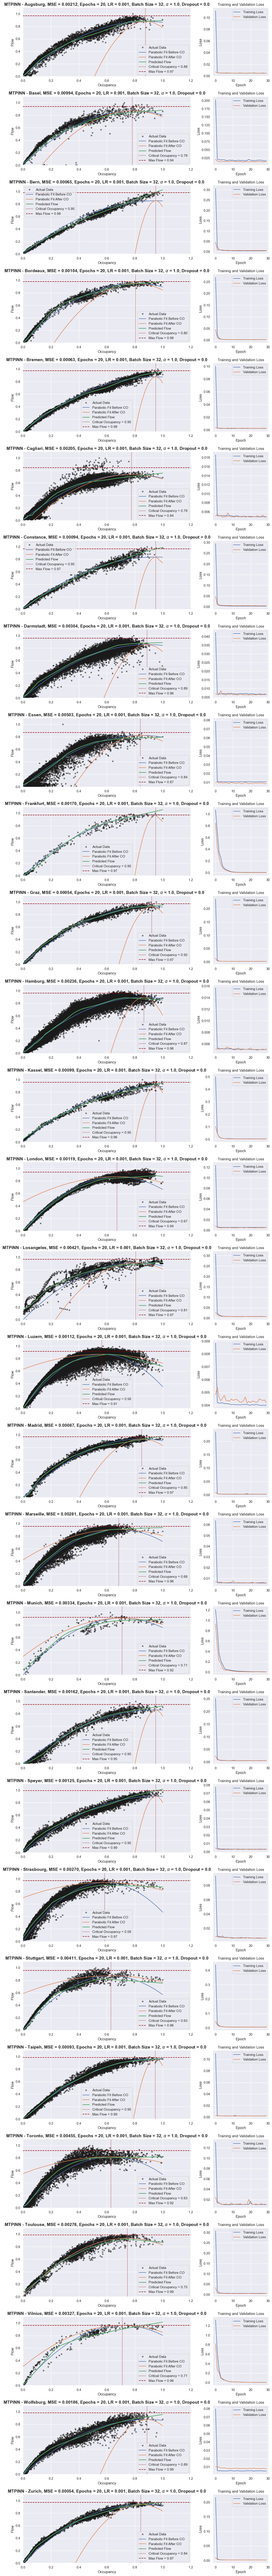

In [9]:
cities = train_df['city'].unique()

batch_results = plot_results_for_batch(cities, train_df, test_df, num_epochs=30, alpha=1.0, learning_rate=0.001, batch_size=32, dropout_prob=0.0)

### Plotting only the 20 cities used in the meta-learning

In [ ]:
# cities = train_df['city'].unique()
cities = ['Augsburg', 'Bern', 'Bordeaux', 'Bremen', 'Darmstadt', 'Graz', 'Hamburg', 'Kassel', 'London', 'Losangeles', 'Madrid', 'Marseille', 'Santander', 'Speyer', 'Strasbourg', 'Stuttgart', 'Taipeh', 'Toronto', 'Toulouse', 'Zurich']

batch_results = plot_results_for_batch(cities, train_df, test_df, num_epochs=30, alpha=1.0, learning_rate=0.001, batch_size=32, dropout_prob=0.0)

**Adjusting the weighting of cd x location, changed from 0.1 to 0.2**

**Adjusting weighting of cd x location to 0.05**

**Run with weighting of cd x location to 0.05, dropout 0.0**

**Let's also try with the penalty for width of parabola 2, while keeping the cd weighting at 0.05 and dropout at 0.0**